In [3]:
import utils
from train import Trainer, Tuner
from pathlib import Path
from model.bigger_leaky_unet import BiggerLeakyUnet
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

## optimization params

What can we optimize?

1. learning rate (very important for us);
2. batch size (unusually important and we forced to use very small batches);
3. image size (224, 256 etc.);
4. using `LeakyReLU` instead of `ReLU` and parameter `alpha`;
5. model: 
    - increase number of layers (looks like we need much bigger model than the `FullUnet`); 
    - add batch normalization (?);
    - kernel initializer (?);
    - change optimiser (?);
6. advanced model:
    - use attention;
    - use transfer learning;

|## | parameter             | value             |
|---| ----------------      | ----------------- |
|(1)| `learning_rate`       | `1e-5`            |
|(2)| `batch size`          | `2`               |
|(3)| `input_shape`         | `256 (?)`         |
|(4)| `alpha`               | `.3 (?)`          |
|   |                       |                   |
|(5)| size of the model     | `(?)`             |
|(6)| batch normalization   | `(?)`             |
|(7)| `kernel_initializer`  | `he_uniform`      |
|(8)| `optimizer`           | `(?)`             |

Here's the list of hyperparameters from cs230 - see [here](https://cs230.stanford.edu/files/C2M3.pdf). It seems we work with the learning rate, it's decay, # of layers and mini-batch size. 

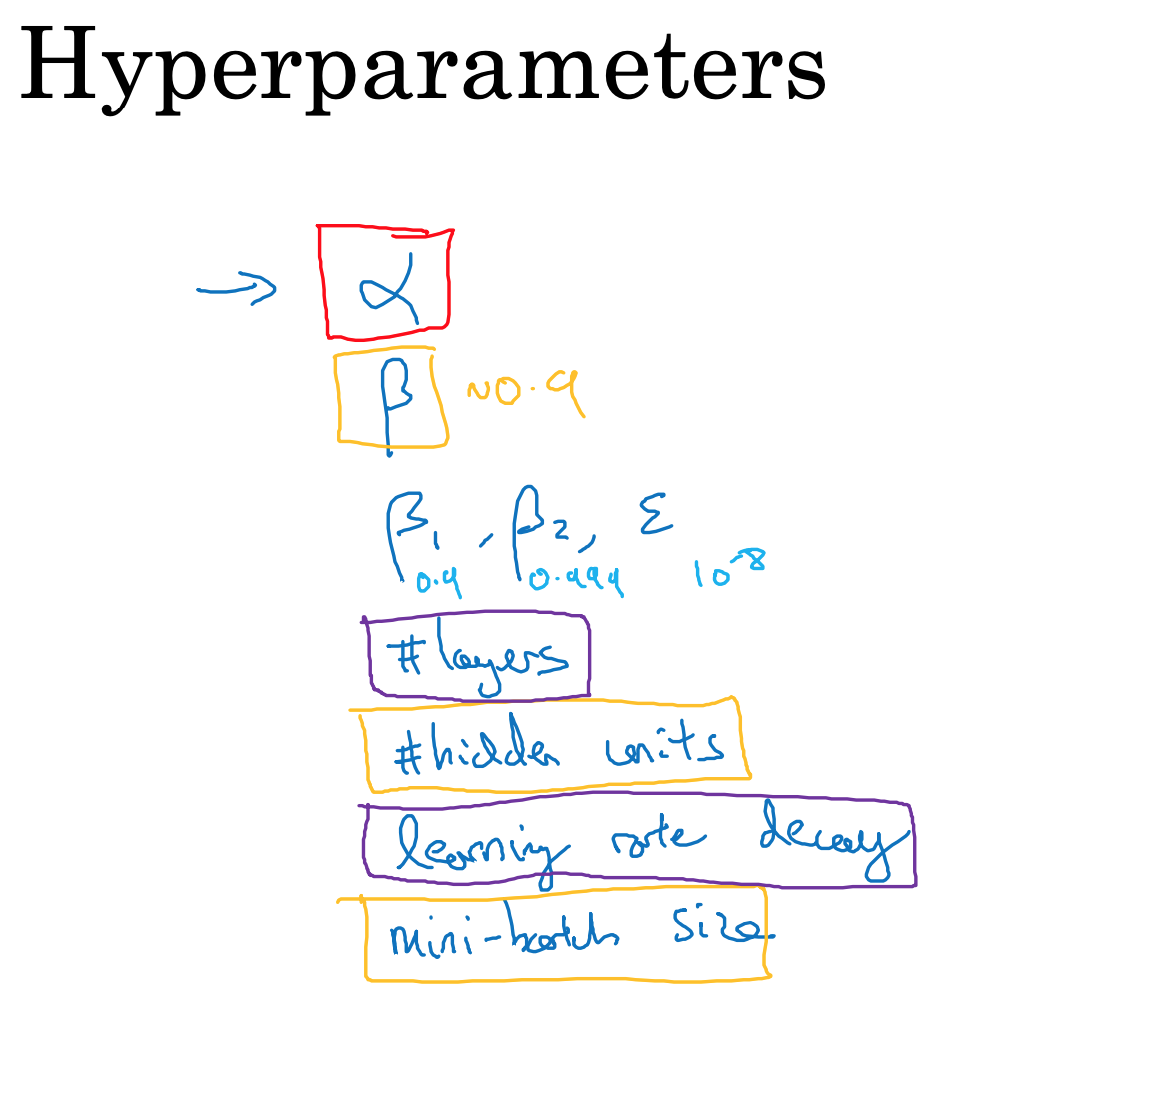

In [29]:
Image('misc/parameter_tuning_cs230.png', width=300, height=400)

For simplicity we do all the training on a toy dataset - 10% of the original dataset. We use augmentation so we can get pretty decent results even on that dataset.

## `BiggerLeakyUnet`

Let's do tuning of the main parameters on `BiggerLeakyUnet` model.

### (1) `learning_rate` 

Let's try to find an optimal learning rate for this model. We start search from a broad range of rates: `(1e-3, 1e-4, 1e-5, 1e-6)` and train our model for just 3 epochs. We then try to look into rates around the best one.

We may see that `1e-3` is too high, `1e-6` is too low. On this plot `1e-4` is a decent choice - but we know that's not the case on the origibal dataset. We start from `1e-5` and go down to `1e-6` but no very fast using factor `.7`. 

In [16]:
Image(url='http://cs231n.github.io/assets/nn3/learningrates.jpeg', width=200, height=200)

In [2]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [3]:
histories_lr_toy = list(dir_path.glob('history_learning_rate*'))

In [4]:
histories_lr_toy = sorted(histories_lr_toy, key=utils.get_param_num, reverse=True)

In [5]:
histories_lr_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-05.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-06.pickle')]

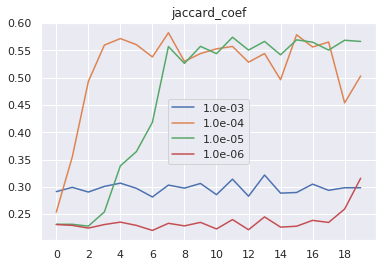

In [6]:
utils.plot_metric_paths('jaccard_coef', histories_lr_toy, param_name='learning_rate')

### (2) `batch_size`

We may see that choice of the `batch_size` matters. Probably we should stick with (unusually) small `batch_size=2`.

In [7]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [8]:
histories_bs_toy = list(dir_path.glob('history_batch_size*'))

In [9]:
histories_bs_toy = sorted(histories_bs_toy, key=utils.get_param_num)

In [10]:
histories_bs_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_2.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_4.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_8.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_16.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_32.pickle')]

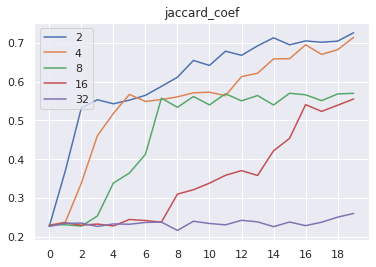

In [11]:
utils.plot_metric_paths('jaccard_coef', histories_bs_toy, param_name='batch_size')

### (3) `input_shape`

In [4]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [13]:
histories_input_shape_toy = list(dir_path.glob('history_input_shape*'))

In [14]:
histories_input_shape_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_input_shape_512.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_input_shape_256.pickle')]

In [15]:
histories_input_shape_toy = sorted(histories_input_shape_toy, key=utils.get_param_num)

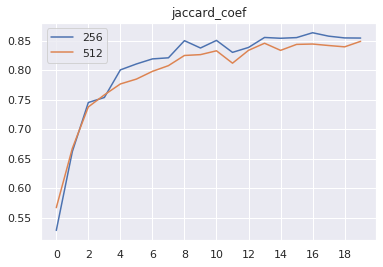

In [18]:
utils.plot_metric_paths('jaccard_coef', histories_input_shape_toy, param_name='input_shape')

### (4) `alpha` 

It looks like that `alpha=.3` (standard in `keras`) works better than low values but only for 20 epochs. For 50 epochs there's no clear winner. We may try to check it on original dataset.

In [12]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [13]:
histories_alpha_toy = list(dir_path.glob('history_alpha*'))

In [14]:
histories_alpha_toy = np.array(sorted(histories_alpha_toy, key=utils.get_param_num))

In [15]:
histories_alpha_toy

array([PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_50epochs_0.001.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.001.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.01.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.1.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.2.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_50epochs_0.3.pickle'),
       PosixPath('experiments/bigger_leaky_unet_toy/history_alpha_0.3.pickle')],
      dtype=object)

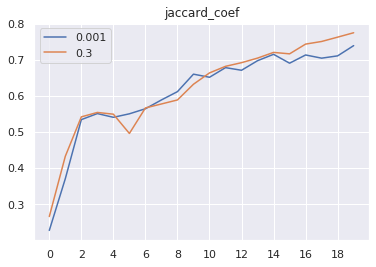

In [19]:
utils.plot_metric_paths('jaccard_coef', histories_alpha_toy[[2, 7]], param_name='alpha')

In [20]:
histories_alpha_toy_50epochs = list(dir_path.glob('history_alpha_50*'))

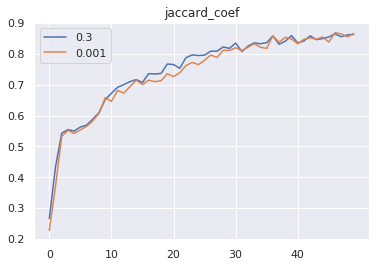

In [22]:
utils.plot_metric_paths('jaccard_coef', histories_alpha_toy_50epochs, x_axis_step=10, param_name='alpha')

### (5) size of the model

### (6) `batch_normalization`

### (7) `kernel_initializer`

By default, `keras` uses Glorot initialization with a uniform distribution that is not suitable for `ReLU` activations. So we have to try He initialization (both uniform and normal). 

We may see that He initialization clearly outperforms Glorot initialization. But difference between different He initializations is not significant.

In [25]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [26]:
histories_kernel_initializer_toy = list(dir_path.glob('history_kernel_initializer*'))

In [27]:
histories_kernel_initializer_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_he_normal.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_glorot_uniform.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_kernel_initializer_he_uniform.pickle')]

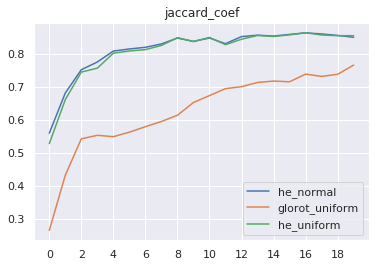

In [29]:
utils.plot_metric_paths('jaccard_coef', histories_kernel_initializer_toy, param_name='kernel_initializer')

### (8) `optimizer`